# Natural Language Processing with Disaster Tweets
[Kaggle Link](https://www.kaggle.com/competitions/nlp-getting-started/)

## Dataset Description
What files do I need?
You'll need train.csv, test.csv and sample_submission.csv.

## What should I expect the data format to be?
Each sample in the train and test set has the following information:

## The text of a tweet
A keyword from that tweet (although this may be blank!)
The location the tweet was sent from (may also be blank)
What am I predicting?
You are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

## Files
train.csv - the training set
test.csv - the test set
sample_submission.csv - a sample submission file in the correct format

## Columns
id - a unique identifier for each tweet
text - the text of the tweet
location - the location the tweet was sent from (may be blank)
keyword - a particular keyword from the tweet (may be blank)
target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [15]:
# import libraries
import sys
from disaster_tweet_detect import data, models
#import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

#import statsmodels as sm
#import keras as k

# logging
import logging
logging.basicConfig(format='%(message)s', level=logging.INFO, stream=sys.stdout)

nltk.download('stopwords')
nltk.download('punkt')

#spacy

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mkhung/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/mkhung/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## EDA - Data Wrangling and Exploration
1. Look at data
2. Compare distribution of targets
3. Tokenize / Word Frequency Map
4. Generate WordCloud
5. Convert tweets to word vectors

In [16]:
# import data
data_train = pd.read_csv('data/train.csv')
data_test = pd.read_csv('data/test.csv')

### Look at Data
1. Raw data slice

We will skip the below items since they are less informative on text

2. <s>Info (count nulls, and look at data types)</s>
3. <s>Describe (shows distribution statistics per column)</s>

#### Summary
'id' will not be useful for classification.
'keyword' only has a few null values.
'location' has several nulls. It may not be a useful feature por predicting disaster tweets as there is no timestamp associated with it.

In [17]:
# this slice shows how each column looks
# additionally, it shows some nulls and values in keyword and location columns
data_train[30:35]

,id,keyword,location,text,target
30,44,NaN,NaN,The end!,0
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0


### Compare distributions
While inspecting the distributions between target classes, we can draw the following conclusions
1. Classes are close to balanced
2. Keywords are not missing too many samples and should be dropped
3. Location is missing ~33% - handling unknown (drop column for now)

Portion of Non-Null Data Available
         id   keyword  location  text
target                               
0       1.0  0.995624  0.664210   1.0
1       1.0  0.987160  0.671354   1.0


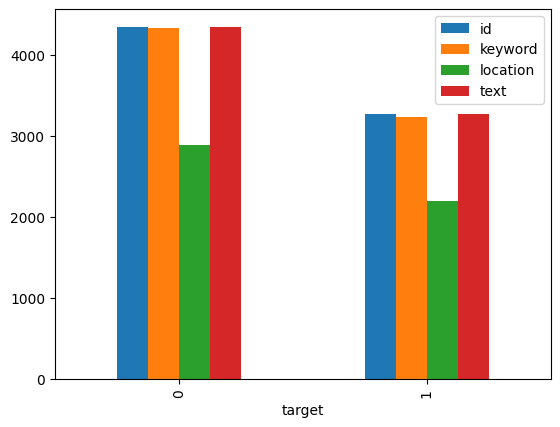

In [18]:
data_train_count = data_train.groupby('target').count()
print('Portion of Non-Null Data Available')
print(data_train_count.div(data_train_count['id'], axis=0))
data_train_count.plot.bar();

## Tokenize / Word Frequency Table with NLTK

In [19]:
# build frequency map
df_words = data.count_words_from_series(data_train.text)

Unique words: 17390


## Generate WordCloud

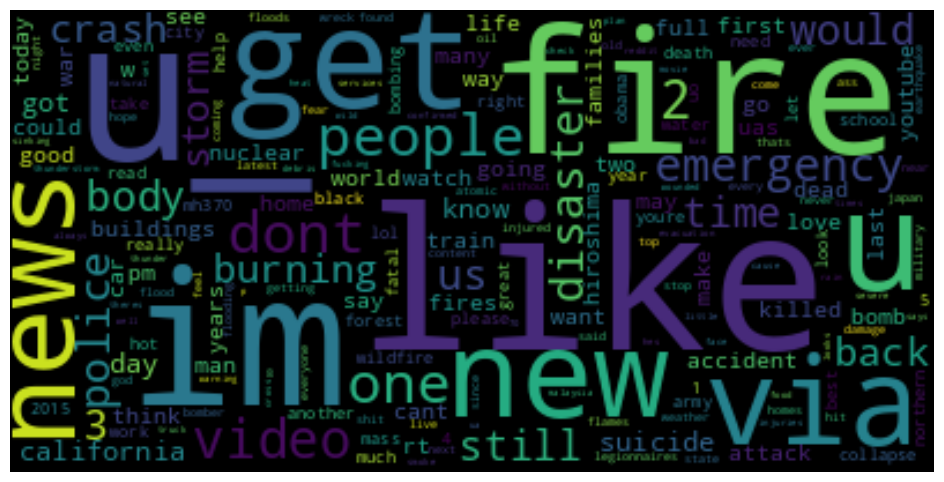

In [20]:
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=dict(zip(df_words.index, df_words['count'])))
#wordcloud.generate_from_frequencies(frequencies=Counter(words))
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Vectorize
TF-IDF is useful for weighing the importance of words. It is computed by multiplying the Term Frequency (TF) vector of each index with a global Inverse Document Frequency (IDF) vector. Unlike the TF vector, the TF-IDF accounts for common words across the document and reduces their weights accordingly.

Vectorize each Tweet. The results are stored in a CSR sparse matrix.

In [21]:
vectorizer = TfidfVectorizer(strip_accents='ascii',
                             preprocessor=data.preprocessor,
                             tokenizer=data.tokenizer,
                             stop_words = None)
csr_tfidf = vectorizer.fit_transform(data_train.text)

# inspect words with the highest max weight vs lowest
df_tfidf = pd.DataFrame.sparse.from_spmatrix(csr_tfidf.max(axis=0), columns=vectorizer.get_feature_names_out()).transpose().rename(columns={0:'tfidf'})
print(df_tfidf.sort_values(by='tfidf', ascending=False))

# inspect shape
#print(csr_tfidf_train.shape)

/Users/mkhung/Documents/Python/UCSD/Capstone/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


             tfidf
survive   1.000000
end       1.000000
smoke     1.000000
looooool  1.000000
accident  1.000000
...            ...
wnw       0.200019
gpv       0.200019
12jst     0.200019
18jst     0.200019
nort      0.183350

[17389 rows x 1 columns]


## ML Models
1. Majority Vote (baseline)
2. Logistic Regression Classifier
3. Ridge Classifier
4. XGBoost Classifer
2. Dense NN - no hidden layers
4. LSTM
7. BERT
3. CNN
5. Random Forest
https://towardsdatascience.com/3-neural-network-architectures-you-need-to-know-for-nlp-5660f11281be

In [22]:
from sklearn.model_selection import train_test_split

# helper class simplifies summarizing models and metrics
summary = models.Summary()

# split data
X = csr_tfidf.toarray()
y = data_train.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

In [23]:
# majority vote classifier
models.evaluate_majority_vote_classifier(X_train, X_test, y_train, y_test, summary)

Majority Vote Classifier accuracy: 0.57035
Majority Vote Classifier roc_auc: 0.5


In [24]:
# logistic regression classifier
models.evaluate_logistic_regression_classifier(X_train, X_test, y_train, y_test, summary)

Logistic Regression Classifier accuracy: 0.736004
Logistic Regression Classifier roc_auc: 0.69768


In [25]:
# ridge regression classifier
models.evaluate_ridge_classifier('disaster_tweet_detect.ridge.model', X_train, X_test, y_train, y_test, summary)

Ridge Classifier accuracy: 0.763914
Ridge Classifier roc_auc: 0.741566


In [40]:
# XGBoost classifier
# xgboost manual: https://xgboost.readthedocs.io/en/stable/parameter.html
# tuning guide: https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
models.evaluate_xgboost_classifier('disaster_tweet_detect.xgboost.model', X_train, X_test, y_train, y_test, summary)

XGBoost Classifier accuracy: 0.729109
XGBoost Classifier roc_auc: 0.704832


In [27]:
print(summary)

                            model       acc   roc_auc
0        Majority Vote Classifier  0.570350  0.500000
0  Logistic Regression Classifier  0.736004  0.697680
0                Ridge Classifier  0.763914  0.741566
0              XGBoost Classifier  0.729109  0.704832


Working on embedding layer
help from:
https://vgpena.github.io/classifying-tweets-with-keras-and-tensorflow/
https://www.tensorflow.org/tutorials/load_data/text#prepare_the_dataset_for_training

In [45]:
# all steps are compiled into a pipeline
# run here to build pickled pipeline
import importlib
from disaster_tweet_detect import pipelines
importlib.reload(pipelines)

pipelines.train_pipeline(data_train.text, data_train.target)

/Users/mkhung/Documents/Python/UCSD/Capstone/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
XGBoost model fitted


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(preprocessor=<function preprocessor at 0x135927ee0>,
                                 strip_accents='ascii',
                                 tokenizer=<function tokenizer at 0x135927f70>)),
                ('xgboost',
                 GridSearchCV(cv=5,
                              estimator=XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=0.95,
                                                      early_stopping_rounds=No...
                                                      importance_type=None,
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_bin=None,
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=2,
                                                      max_leaves=None,
                                                      min_child_weight=1,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=180,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None, ...),
                              n_jobs=4, param_grid={}, scoring='roc_auc',
                              verbose=3))])

In [46]:
pipeline = pipelines.load_pipeline('disaster_tweet_detect.pipeline')
type(pipeline)

sklearn.pipeline.Pipeline

In [0]:
idx = 2
print(f'{data_train.text[idx]}: {pipeline.predict([data_train.text[idx]])}')

In [58]:
type(pipeline.predict([data_train.text[idx]]))

numpy.ndarray

In [28]:
import json
import tensorflow as tf
from keras.models import Model
from keras.layers import TextVectorization, Input, Embedding, LSTM, Dropout, Dense
from keras.losses import BinaryCrossentropy

# limit to only using the most popular words
vocab_size = 5000
max_seq_length = 140 # since tweets can have 280 char, if half are spaces, we have a max of 140 words
embedding_dim = 64

# build vectorizer layer and adapt to training data
vectorize_layer = TextVectorization(max_tokens=vocab_size,
                                    output_mode='int',
                                    output_sequence_length=max_seq_length)
vectorize_layer.adapt(X_train)      # used for sequences

# save dictionary to disk
dictionary = vectorize_layer.get_vocabulary()
with open('dictionary.json', 'w') as f_dict:
    json.dump(dictionary, f_dict)

# example of a vectorized text
print(X_train[0])
vectorize_layer(X_train[0])

ValueError: in user code:

    File "/Users/mkhung/Documents/Python/UCSD/Capstone/venv/lib/python3.8/site-packages/keras/engine/base_preprocessing_layer.py", line 123, in adapt_step  *
        self.update_state(data)
    File "/Users/mkhung/Documents/Python/UCSD/Capstone/venv/lib/python3.8/site-packages/keras/layers/preprocessing/text_vectorization.py", line 475, in update_state  **
        self._lookup_layer.update_state(self._preprocess(data))
    File "/Users/mkhung/Documents/Python/UCSD/Capstone/venv/lib/python3.8/site-packages/keras/layers/preprocessing/text_vectorization.py", line 570, in _preprocess
        raise ValueError(

    ValueError: When using `TextVectorization` to tokenize strings, the input rank must be 1 or the last shape dimension must be 1. Received: inputs.shape=(None, 17389) with rank=2


In [ ]:
# build model
input_tensor = Input(dtype=tf.string, shape=(1,))
vect_tensor = vectorize_layer(input_tensor)
embed_tensor = Embedding(input_dim=vocab_size,
                         output_dim=embedding_dim)(vect_tensor)
lstm_tensor = LSTM(1, activation='relu')(embed_tensor)
#dropout_tensor = Dropout(0.2)(lstm_tensor)
output_tensor = Dense(1, activation='sigmoid')(lstm_tensor)

model = Model(input_tensor, output_tensor)
model.compile(optimizer='adam',
              loss=BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

In [ ]:
# plot the model
from keras.utils import plot_model

plot_model(model, to_file='model_lstm_0001.png')
img = plt.imread('model_lstm_0001.png')
plt.imshow(img)
plt.show()

In [ ]:
model.fit(X_train, y_train, batch_size=64, validation_data=(X_train,y_train), verbose=True)

In [ ]:
model.evaluate(X_train,y_train)

In [ ]:
print(summary)

## Survey of Existing Solutions

TF-IDF

### Potential Libraries
1. fast.ai
2. spaCy
3. Flair
4. gensim
5. fastText
6. Stanford Core NLP

### Additional vectorizers
Tweet2Vec
Generates embeddings from characters rather than words (i.e. Word2Vec). Based off a character level CNN-LSTM network.
https://lsm.media.mit.edu/papers/tweet2vec_vvr.pdf